In [1]:
#!g1.1
%load_ext autoreload
%autoreload 2

In [2]:
#!g1.1
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
#!g1.1
from pathlib import Path

import pandas as pd
import torch

from src.augmentations import DefaultWaveAugmentations, DefaultWave2Spec
from src.configs import DefaultConfig, DistillationConfig
from src.data_utils import get_dataloaders, SpeechCommandsDataset
from src.models import CRNN
from src.trainers import DefaultTrainer, DistillationTrainer
from src.utils import count_parameters, seed_all

In [4]:
#!g1.1
CHECKPOINT_DIR = Path('checkpoints')
DATA_DIR = Path('data/speech_commands')
TRAIN_CSV = Path('data/train.csv')
VAL_CSV = Path('data/val.csv')

In [5]:
#!g1.1
train_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(TRAIN_CSV))
train_set.transforms = DefaultWaveAugmentations(DATA_DIR)
val_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(VAL_CSV))

In [6]:
#!g1.1
_ = seed_all()
teacher_config = DefaultConfig()
teacher = CRNN(teacher_config)
teacher.load_state_dict(torch.load(CHECKPOINT_DIR / 'baseline.pth',
                        map_location=teacher_config.device))
teacher = teacher.eval()

Теперь сделаем дистилляцию:

In [7]:
#!g1.1
def do_distillation(config: DistillationConfig):
    seed_all()

    train_loader, val_loader = get_dataloaders(
        train_set, val_set, config.batch_size, pin_memory=False)
    train_wave2spec = DefaultWave2Spec(is_train=True, config=config)
    val_wave2spec = DefaultWave2Spec(is_train=False, config=config)

    student = CRNN(config).train()
    opt = torch.optim.Adam(
        student.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    trainer = DistillationTrainer(
        opt=opt,
        train_loader=train_loader,
        val_loader=val_loader,
        device=config.device,
        teacher=teacher,
        student=student,
        train_wave2spec=train_wave2spec,
        val_wave2spec=val_wave2spec,
        temp=config.temp,
        alpha=config.alpha,
    )
    trainer.train(n_epochs=config.num_epochs)
    return trainer

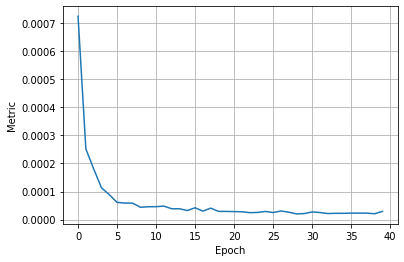

END OF EPOCH 40, val metric: 2.9342431456375515e-05


2.0331434608881712e-05

In [8]:
#!g1.1
config = DistillationConfig(
    num_epochs=40,
    hidden_size=32,
)
trainer = do_distillation(config)
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs32.pth')
trainer.best_score

Теперь попробуем еще уменьшить `hidden_size`:

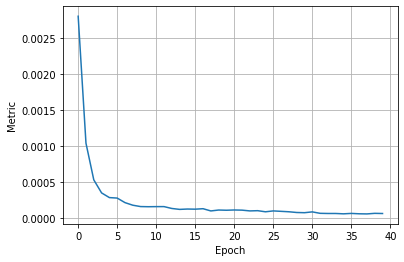

END OF EPOCH 40, val metric: 6.290690282639464e-05


5.731531074288359e-05

In [9]:
#!g1.1
config = DistillationConfig(
    num_epochs=40,
    hidden_size=16,
)
trainer = do_distillation(config)
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs16.pth')
trainer.best_score

Теперь попробуем еще уменьшить сверточную сеть:

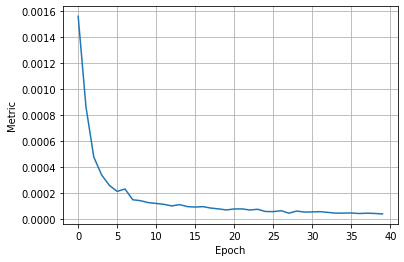

END OF EPOCH 40, val metric: 4.26082897292091e-05


4.26082897292091e-05

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [10]:
#!g1.1
config = DistillationConfig(
    num_epochs=40,
    hidden_size=16,
    cnn_out_channels=4,
    stride=(5, 10),
    kernel_size=(10, 20),
)
trainer = do_distillation(config)
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs16_c4.pth')
trainer.best_score